# **Modelado Inicial de Algoritmos de Clasificación**

Este notebook tiene como objetivo realizar una **primera toma de contacto** con distintos modelos de clasificación **sin explorar el ajuste de hiperparámetros**. En esta fase preliminar, se entrenarán y evaluarán los modelos utilizando sus valores predeterminados con el fin de analizar el impacto de las variables en la predicción de la propensión de compra.

El enfoque se centra en observar el comportamiento inicial de los modelos, identificar las variables más influyentes y determinar posibles mejoras a implementar en la siguiente fase de ajuste de hiperparámetros.

**Objetivos.**
- Entrenar modelos de clasificación sin ajuste de hiperparámetros.
- Evaluar el rendimiento de los modelos en términos de métricas básicas.
- Analizar la importancia de las variables en la predicción.
- Establecer una base para la optimización posterior en la búsqueda de hiperparámetros.

**Modelos Considerados.**
En esta fase inicial, se probarán los siguientes modelos:
1. **Random Forest**: Algoritmo basado en el ensamblado de múltiples árboles de decisión, robusto frente al sobreajuste y adecuado para datos con relaciones no lineales.
2. **XGBoost**: Modelo de boosting basado en gradientes que optimiza el ajuste de los datos mediante regularización, ampliamente utilizado en entornos de alto rendimiento.
3. **AdaBoost**: Algoritmo de boosting adaptativo que ajusta modelos débiles de forma iterativa para mejorar la capacidad predictiva.
4. **Gradient Boosting (GBM)**: Modelo de boosting que optimiza el error a través de gradientes, permitiendo una mayor flexibilidad en la modelización.

Estos modelos serán evaluados en función de sus métricas clave para obtener una idea general de su rendimiento antes de proceder con un ajuste más fino en el siguiente notebook de optimización de hiperparámetros.

## **Importación de librerías.**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importación e información de Dataframes.**

In [200]:
df = pd.read_csv('../data/processed/IA_PROPENSITY_TRAIN_v2.csv', index_col=0)
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo,COMUNIDAD_AUT
CODE,,,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,0.0,1,0,0,1,1,1,0,0,2.0,0,3.0,1,2892,0,0,1,0,0,2
CLI2,0,0,0,0.0,1,0,0,0,1,0,0,0,2.0,1,0.0,0,1376,7187,0,1,2,0,6
CLI3,0,0,0,0.0,1,2,0,1,1,0,0,0,3.0,0,0.0,0,1376,0,1,2,0,3,8
CLI4,0,0,0,0.0,1,1,0,0,1,1,0,0,3.0,1,3.0,1,2015,7256,1,2,1,5,13
CLI5,0,0,0,0.0,1,1,0,0,2,1,0,1,4.0,0,0.0,0,1818,0,1,2,0,3,4


### **División en conjuntos de entrenamiento y prueba.**

Para evaluar el rendimiento de los modelos de clasificación, es fundamental dividir el conjunto de datos en dos subconjuntos:

- **Conjunto de entrenamiento (Train Set)**: Se utiliza para ajustar los parámetros del modelo y aprender patrones en los datos.
- **Conjunto de prueba (Test Set)**: Se usa para evaluar el rendimiento del modelo en datos no vistos, asegurando que generaliza correctamente.

En este notebook, dividiremos los datos aplicando una proporción típica de **80% entrenamiento y 20% prueba**. Para asegurar reproducibilidad, se establece una **semilla aleatoria (`random_state`)**.


La variable **Tiempo** fue excluida del modelo ya que representa los años entre compras, fue excluida debido a su **alta correlación** con la variable objetivo. Una correlación tan alta puede generar multicolinealidad, lo que afecta negativamente el rendimiento del modelo.

In [201]:
X = df.drop(['Mas_1_coche', 'Tiempo'], axis=1) # Features
y = df['Mas_1_coche'] # Target

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

### **Verificación de balance de clases.**

En problemas de clasificación, es importante analizar la distribución de la variable objetivo para determinar si existe un **desequilibrio de clases**. Un conjunto de datos desbalanceado puede sesgar el modelo hacia la clase mayoritaria, afectando la capacidad de predicción.

Para evaluar esto, se analiza la proporción de cada clase en el conjunto de entrenamiento y prueba. Si se detecta un fuerte desequilibrio, se pueden aplicar estrategias como:
- **Reajuste de pesos en los modelos.**
- **Técnicas de sobremuestreo o submuestreo.**
- **Métricas alternativas**: En lugar de accuracy, priorizar **F1-score, AUC-ROC o Recall**.


In [203]:
y_train.value_counts()

Mas_1_coche
0    32070
1    12787
Name: count, dtype: int64

In [204]:
y_test.value_counts()

Mas_1_coche
0    8118
1    3097
Name: count, dtype: int64

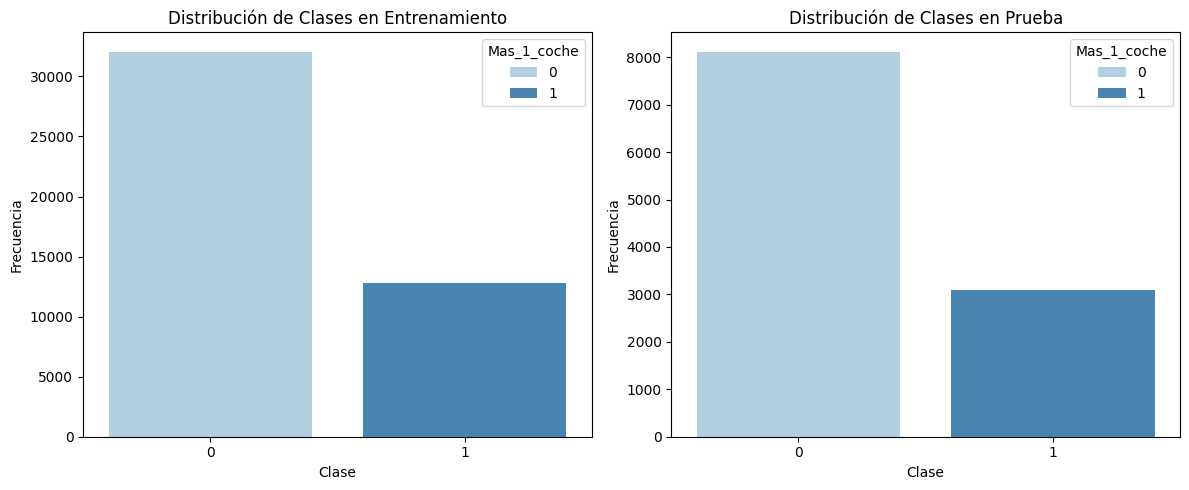

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribución en el conjunto de entrenamiento.
sns.countplot(x=y_train, ax=axes[0], palette='Blues' , hue=y_train)
axes[0].set_title("Distribución de Clases en Entrenamiento")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Frecuencia")
# Distribución en el conjunto de prueba.
sns.countplot(x=y_test, ax=axes[1], palette='Blues', hue=y_test)
axes[1].set_title("Distribución de Clases en Prueba")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Dado el objetivo del proyecto de predecir la **propensión de compra de un segundo vehículo**, nos enfocaremos en la métrica de **Recall** para evaluar el rendimiento de nuestros modelos de clasificación.

El conjunto de datos presenta un **desequilibrio de clases**, con una mayor proporción de clientes que **no compran un segundo vehículo** en comparación con aquellos que sí lo hacen. En este contexto, la métrica de **Accuracy** podría ser engañosa, ya que un modelo que simplemente predice la clase mayoritaria (sin identificar correctamente a los compradores potenciales) puede obtener una alta precisión sin ser realmente útil.

**Importancia del Recall en el Contexto del Negocio.** El objetivo principal del modelo es **optimizar las campañas de marketing**, identificando clientes con **alta probabilidad de recompra**. Un alto **Recall** significa que estamos capturando correctamente a estos clientes, lo que permite a la empresa **dirigir sus esfuerzos de marketing de manera más eficiente** y **reducir costos operativos**.

- **Recall alto** → Mayor cantidad de clientes interesados correctamente identificados.
- **Recall bajo** → Oportunidades de venta perdidas debido a predicciones erróneas.

Según el **Project Charter**, uno de los principales problemas a resolver es la **falta de segmentación efectiva**, lo que lleva a una inversión ineficiente en campañas publicitarias. Un modelo con alto **Recall** contribuirá a la mejora de la tasa de conversión, ya que permitirá identificar a los clientes más propensos a comprar, alineándose con los objetivos estratégicos del negocio:
- **Mejor segmentación** de clientes para campañas personalizadas.
- **Reducción del costo de adquisición de clientes** mediante campañas más dirigidas.
- **Mayor fidelización de clientes** al enfocarse en usuarios con alta probabilidad de recompra.

Por lo tanto, en la evaluación de modelos nos centraremos en **maximizar el Recall sin sacrificar excesivamente otras métricas como la precisión y el AUC-ROC**, para garantizar una implementación efectiva en el negocio.

## **Modelado con Random Forest.**
El modelo de Random Forest es un algoritmo de aprendizaje supervisado basado en el ensamblado de múltiples árboles de decisión. Su principal ventaja radica en su capacidad para reducir el sobreajuste y mejorar la precisión general del modelo mediante la combinación de predicciones de varios árboles.

- Construye múltiples árboles de decisión y combina sus predicciones para mejorar la estabilidad y precisión del modelo.
- Reduce el sobreajuste en comparación con los árboles de decisión individuales.
- Puede manejar datos con valores faltantes y escalar bien en conjuntos de datos grandes.

Permite la interpretación de la importancia de las variables, ayudando a identificar las características más relevantes en la predicción.

#### **Entrenamiento.**

In [206]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

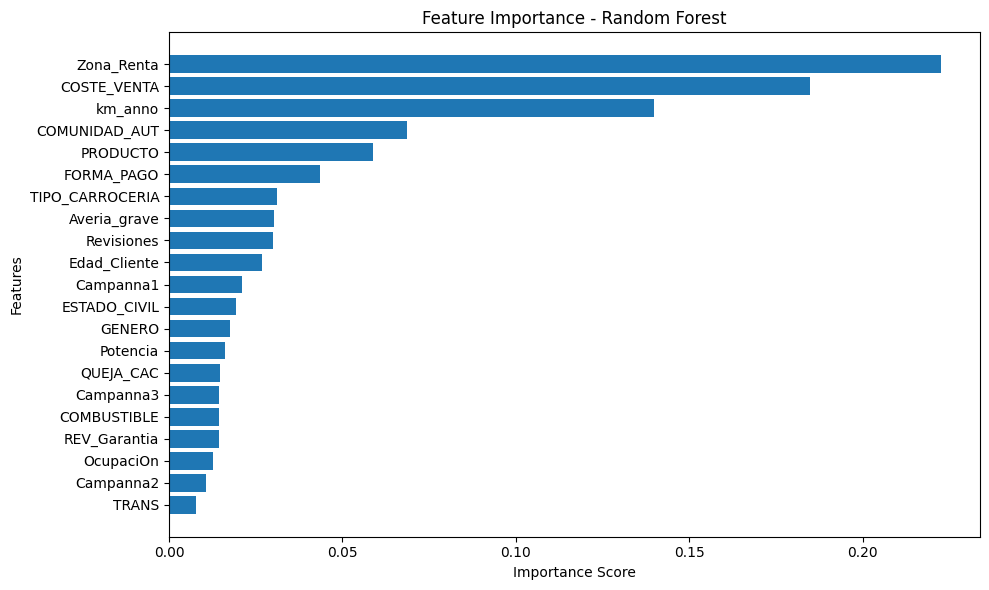

In [207]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [208]:
importance_df.tail(3)

,Feature,Importance
8,OcupaciOn,0.012673
10,Campanna2,0.010689
4,TRANS,0.007850


La gráfica muestra la importancia relativa de cada variable en el modelo **Random Forest** para predecir la propensión de compra de un segundo coche. Se pueden extraer varias observaciones clave:

**Variables más influyentes.**
   - **Zona_Renta:** La variable con mayor peso en la predicción, lo que sugiere que el nivel de renta de la zona donde reside el cliente influye significativamente en la decisión de compra.
   - **Coste de Venta:** Representa la suma de descuentos aplicados en la venta del vehículo, lo que indica que el precio final después de descuentos tiene un impacto significativo en la decisión de compra.
   - **KM Año:** El kilometraje anual promedio también resulta clave, probablemente reflejando el uso del vehículo y la necesidad de renovación.
   - **Comunidad autónoma y Producto:** Factores geográficos y el tipo de producto parecen influir de manera notable en la propensión de compra.

**Variables con menor impacto.**
   - Variables como **REV Garantia, Ocupación y Campaña 2** tienen una baja contribución al modelo, lo que sugiere que su impacto en la decisión de compra es mínimo.
   - **La variable TRANS tiene la menor importancia y, por lo tanto, se puede descartar en futuras iteraciones del modelo** para optimizar su rendimiento sin pérdida significativa de información.

El análisis revela que las **variables económicas y geográficas** son los principales factores que afectan la decisión de compra de un segundo vehículo. **La variable TRANS será descartada en iteraciones futuras debido a su baja contribución**, y se evaluará la necesidad de incluir otras transformaciones de datos para mejorar el modelo. **En la siguiente fase de optimización de hiperparámetros**, se evaluará si ajustar la profundidad de los árboles o el número de estimadores mejora la capacidad predictiva del modelo.

### **Evaluación.**

In [209]:
print("Train set score (Accuracy) =", rf_model.score(X_train, y_train))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.998573243863834
Test set score (Accuracy) = 0.8603655818100758
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7455 │            663 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            903 │           2194 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      8118
           1       0.77      0.71      0.74      3097

    accuracy                           0.86     11215
   macro avg       0.83      0.81      0.82     11215
weighted avg       0.86      0.86      0.86     11215



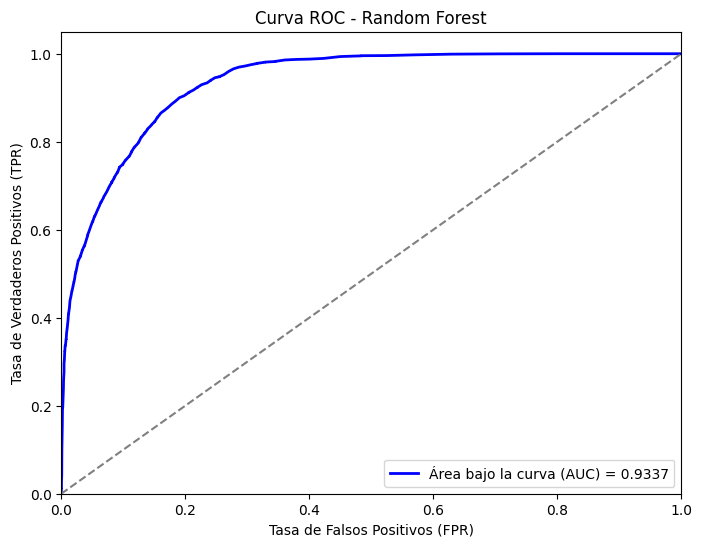

In [210]:
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase 1.

# Cálculo de la Curva ROC.
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficación de la Curva ROC.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Línea base.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [211]:
results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, rf_model.predict(X_test))],
    'Precision': [precision_score(y_test, rf_model.predict(X_test))],
    'Recall': [recall_score(y_test, rf_model.predict(X_test))],
    'F1': [f1_score(y_test, rf_model.predict(X_test))],
    'AUC': [roc_auc]
})
results.head()

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.5,0.860366,0.767938,0.708428,0.736984,0.933726


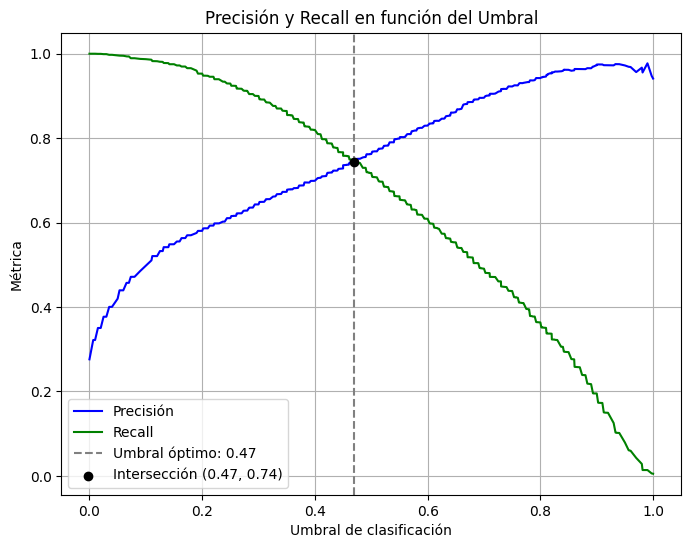

In [212]:
# Obtener probabilidades del modelo.
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersección entre precisión y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral óptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersección ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.grid(True)
plt.legend()
plt.title("Precisión y Recall en función del Umbral")
plt.show()

In [213]:
# Ajuste de umbral.
nuevo_umbral = 0.47
y_pred_new = (y_scores >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, rf_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral.
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.998573243863834
Test set score (Accuracy) = 0.8587605884975479
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7314 │            804 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            780 │           2317 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8118
           1       0.74      0.75      0.75      3097

    accuracy                           0.86     11215
   macro avg       0.82      0.82      0.82     11215
weighted avg       0.86      0.86      0.86     11215



In [214]:
new_results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Umbral': [0.47],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_scores)]
})

results = pd.concat([results, new_results], ignore_index=True)
results.head()

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726


El modelo de **Random Forest** ha demostrado un rendimiento sólido en la predicción de la propensión de compra de un segundo vehículo, alineándose con los objetivos clave del **Project Charter**. Con una alta precisión y un AUC destacado, el modelo es capaz de identificar de manera efectiva a los clientes con mayor probabilidad de realizar una recompra, lo que permitirá optimizar las estrategias de marketing y ventas.

La capacidad del modelo para equilibrar **precisión** y **recall** es particularmente importante, ya que no solo busca predecir correctamente a los clientes propensos a comprar, sino también minimizar los falsos positivos. Esto es crucial para reducir costos operativos y maximizar el retorno de las campañas dirigidas. Además, el ajuste del umbral de clasificación ha permitido mejorar el **recall**, lo que significa que el modelo es más efectivo para capturar a los clientes que realmente tienen una alta probabilidad de recompra.

## **Modelado con XGBoost.**

### **Entrenamiento.**

In [215]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

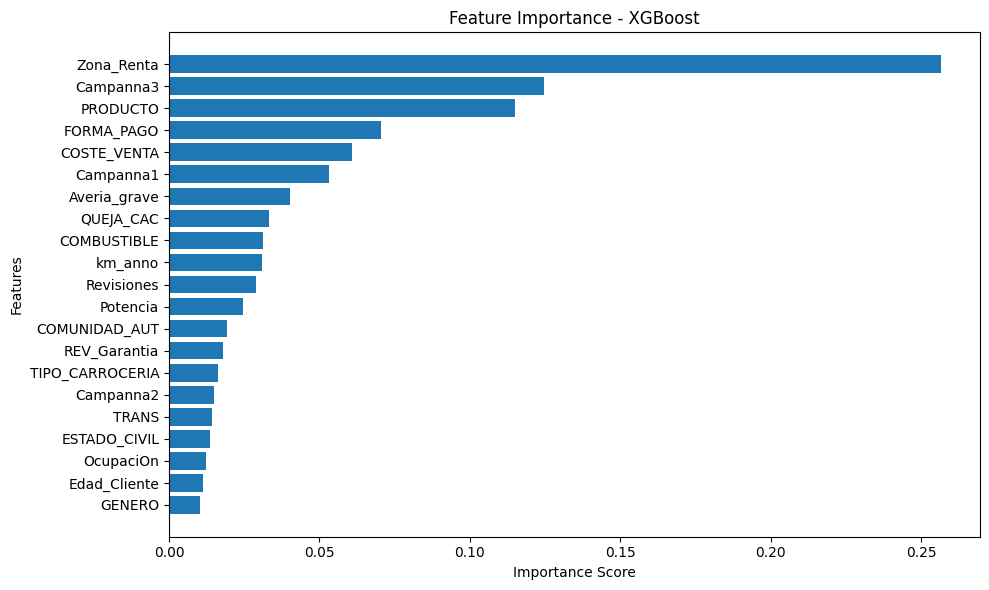

In [216]:
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

In [217]:
importance_df.tail(3)

,Feature,Importance
8,OcupaciOn,0.012261
19,Edad_Cliente,0.011203
7,GENERO,0.010273


En la evaluación de importancia de características obtenida con el modelo **XGBoost**, observamos que algunas variables tienen valores relativamente bajos de importancia en comparación con otras. Sin embargo, ninguna de estas variables será eliminada, ya que pueden aportar información relevante en la interacción con otras características.

### **Evaluación.**

In [218]:
print("Train set score (Accuracy) =", accuracy_score(y_train, xgb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, xgb_model.predict(X_test)))

# Matriz de confusión
conf_mat = confusion_matrix(y_test, xgb_model.predict(X_test))
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, xgb_model.predict(X_test)))

Train set score (Accuracy) = 0.9190315892725773
Test set score (Accuracy) = 0.8715113687026304
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7474 │            644 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            797 │           2300 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      8118
           1       0.78      0.74      0.76      3097

    accuracy                           0.87     11215
   macro avg       0.84      0.83      0.84     11215
weighted avg       0.87      0.87      0.87     11215



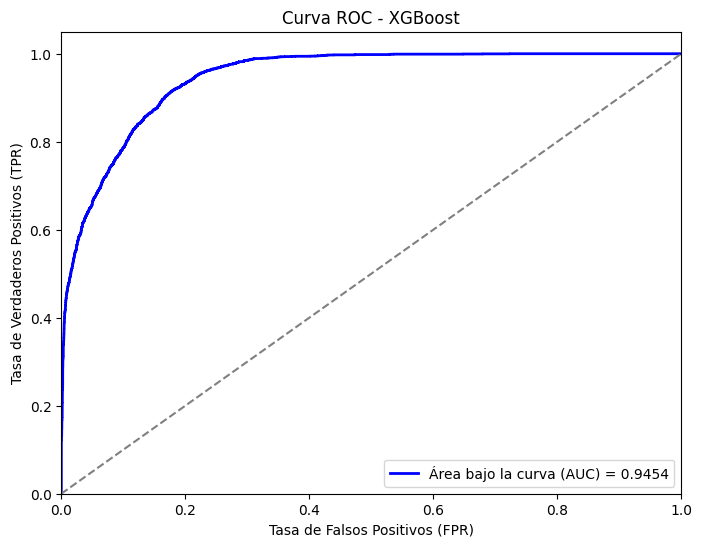

In [219]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [220]:
new_results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, xgb_model.predict(X_test))],
    'Precision': [precision_score(y_test, xgb_model.predict(X_test))],
    'Recall': [recall_score(y_test, xgb_model.predict(X_test))],
    'F1': [f1_score(y_test, xgb_model.predict(X_test))],
    'AUC': [roc_auc]
})
results = pd.concat([results, new_results], ignore_index=True)
results.head()

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399


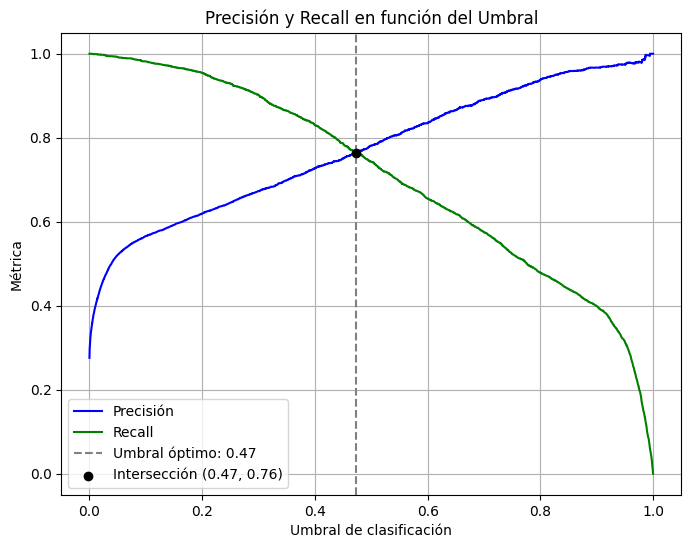

In [221]:
# Obtener probabilidades del modelo.
y_scores = xgb_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersección entre precisión y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral óptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersección ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.grid(True)
plt.legend()
plt.title("Precisión y Recall en función del Umbral")
plt.show()

In [222]:
nuevo_umbral = 0.47
y_pred_new = (y_probs >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, xgb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.9190315892725773
Test set score (Accuracy) = 0.8696388765046812
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7377 │            741 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            721 │           2376 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      8118
           1       0.76      0.77      0.76      3097

    accuracy                           0.87     11215
   macro avg       0.84      0.84      0.84     11215
weighted avg       0.87      0.87      0.87     11215



In [223]:
new_results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Umbral': [0.47],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_probs)]
})

results = pd.concat([results, new_results], ignore_index=True)
results.head()

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399
3,XGBoost,0.47,0.869639,0.762271,0.767194,0.764725,0.945399


El modelo **XGBoost** ha mostrado un rendimiento excepcional en la predicción de la propensión de compra de un segundo vehículo, cumpliendo con los objetivos establecidos en el **Project Charter**. Con una precisión y un AUC aún más altos que los del modelo anterior, **XGBoost** demuestra una capacidad superior para identificar a los clientes con mayor probabilidad de realizar una recompra. Esto es fundamental para optimizar las estrategias de marketing y ventas, ya que permite enfocar los recursos en los clientes más propensos a comprar, maximizando así el retorno de las campañas.

El ajuste del umbral de clasificación ha permitido mejorar el **recall**, lo que significa que el modelo es más efectivo para capturar a los clientes que realmente tienen una alta probabilidad de recompra, sin sacrificar significativamente la precisión. Este equilibrio entre **precisión** y **recall** es clave para garantizar que las campañas sean tanto efectivas como eficientes, reduciendo costos operativos y mejorando la rentabilidad.

## **Modelado con Gradient Boosting.**

### **Entrenamiento.**

In [224]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

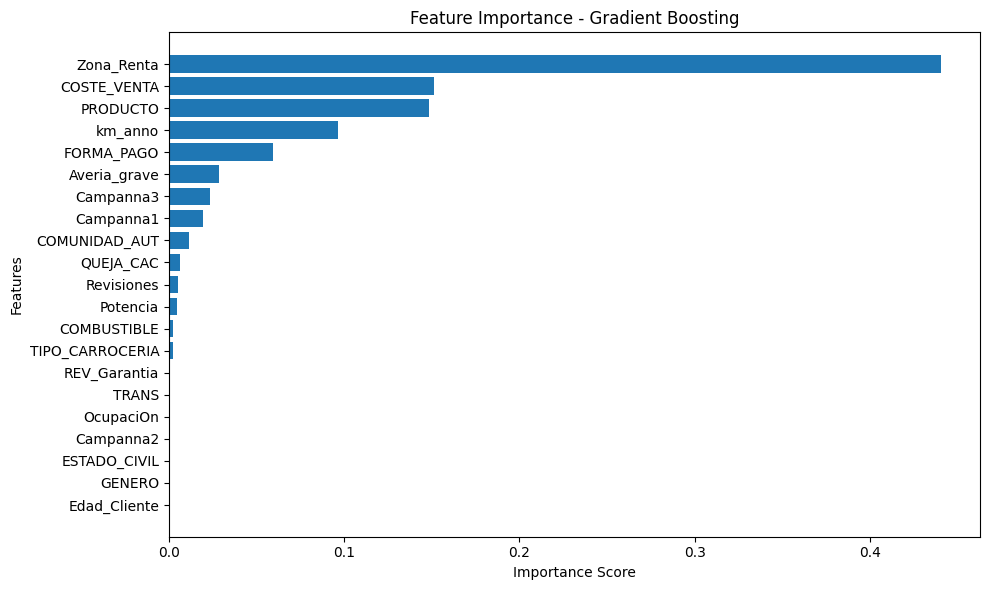

In [225]:
feature_importances = gb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.show()

In [226]:
importance_df.tail(8)

,Feature,Importance
1,TIPO_CARROCERIA,0.002085
13,REV_Garantia,0.000232
4,TRANS,0.000000
8,OcupaciOn,0.000000
10,Campanna2,0.000000
6,ESTADO_CIVIL,0.000000
7,GENERO,0.000000
19,Edad_Cliente,0.000000


En la evaluación de importancia de características obtenida con el modelo **Gradient Boosting**, observamos que algunas variables tienen importancia extremadamente baja o nula. En este caso, se puede considerar la eliminación de ciertas variables para mejorar la eficiencia del modelo sin afectar su rendimiento.

Las variables con importancia de características nula pueden ser eliminadas, no tienen contribución al modelo. A su vez, se podría eliminar también la columna **REV Garantia** por tener un impacto insignificante.

### **Evaluación.**

In [227]:
# Evaluación del modelo
print("Train set score (Accuracy) =", accuracy_score(y_train, gb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, gb_model.predict(X_test)))

# Matriz de confusión
conf_mat = confusion_matrix(y_test, gb_model.predict(X_test))
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, gb_model.predict(X_test)))

Train set score (Accuracy) = 0.8438816684129568
Test set score (Accuracy) = 0.8430673205528311
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7408 │            710 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1050 │           2047 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      8118
           1       0.74      0.66      0.70      3097

    accuracy                           0.84     11215
   macro avg       0.81      0.79      0.80     11215
weighted avg       0.84      0.84      0.84     11215



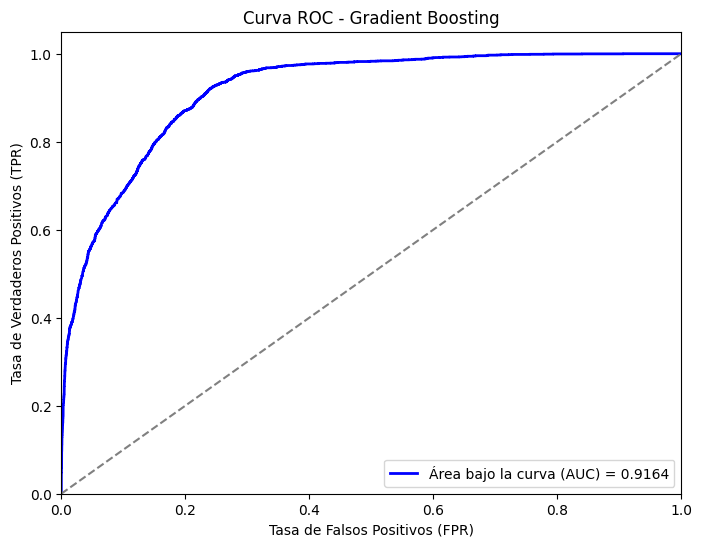

In [228]:
y_probs = gb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

In [229]:
new_results = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, gb_model.predict(X_test))],
    'Precision': [precision_score(y_test, gb_model.predict(X_test))],
    'Recall': [recall_score(y_test, gb_model.predict(X_test))],
    'F1': [f1_score(y_test, gb_model.predict(X_test))],
    'AUC': [roc_auc]
})
results = pd.concat([results, new_results], ignore_index=True)
results.head()

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399
3,XGBoost,0.47,0.869639,0.762271,0.767194,0.764725,0.945399
4,Gradient Boosting,0.50,0.843067,0.742474,0.660962,0.699351,0.916391


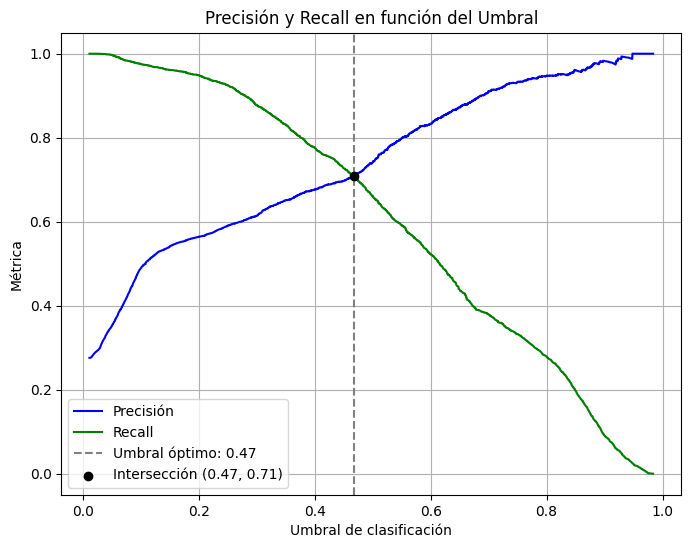

In [230]:
# Obtener probabilidades del modelo.
y_scores = gb_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersección entre precisión y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral óptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersección ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.grid(True)
plt.legend()
plt.title("Precisión y Recall en función del Umbral")
plt.show()

In [231]:
nuevo_umbral = 0.47
y_pred_new = (y_probs >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, gb_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.8438816684129568
Test set score (Accuracy) = 0.8391440035666518
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7228 │            890 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            914 │           2183 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      8118
           1       0.71      0.70      0.71      3097

    accuracy                           0.84     11215
   macro avg       0.80      0.80      0.80     11215
weighted avg       0.84      0.84      0.84     11215



In [232]:
new_results = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Umbral': [0.47],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_probs)]
})

results = pd.concat([results, new_results], ignore_index=True)
display(results)

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399
3,XGBoost,0.47,0.869639,0.762271,0.767194,0.764725,0.945399
4,Gradient Boosting,0.50,0.843067,0.742474,0.660962,0.699351,0.916391
5,Gradient Boosting,0.47,0.839144,0.710381,0.704876,0.707618,0.916391


El modelo **Gradient Boosting** ha mostrado un rendimiento adecuado en la predicción de la propensión de compra de un segundo vehículo, aunque con una precisión y AUC inferiores a los de otros modelos evaluados. A pesar de su estabilidad y capacidad para manejar datos complejos, su desempeño indica que no es la opción más eficiente para identificar clientes con alta probabilidad de recompra en este caso.

El ajuste del umbral ha permitido mejorar ligeramente el **recall**, lo que implica que el modelo es más eficaz en la detección de clientes que realmente comprarán un segundo coche. Sin embargo, esta mejora en **recall** no se traduce en un aumento significativo del **F1-score**, lo que sugiere que el modelo no logra un equilibrio óptimo entre capturar clientes potenciales y evitar falsos positivos.

Dado el rendimiento observado, **Gradient Boosting** puede no ser la mejor opción para este problema específico, especialmente si se busca maximizar la efectividad de las campañas de marketing y ventas. En comparación con otros modelos como **XGBoost** y **Random Forest**, su capacidad predictiva es inferior, lo que sugiere que su uso debería reconsiderarse o que requeriría ajustes adicionales en sus hiperparámetros para mejorar su desempeño.

## **Modelado con AdaBoost.**

### **Entrenamiento.**

In [233]:
ab_model = AdaBoostClassifier(random_state=42)
ab_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

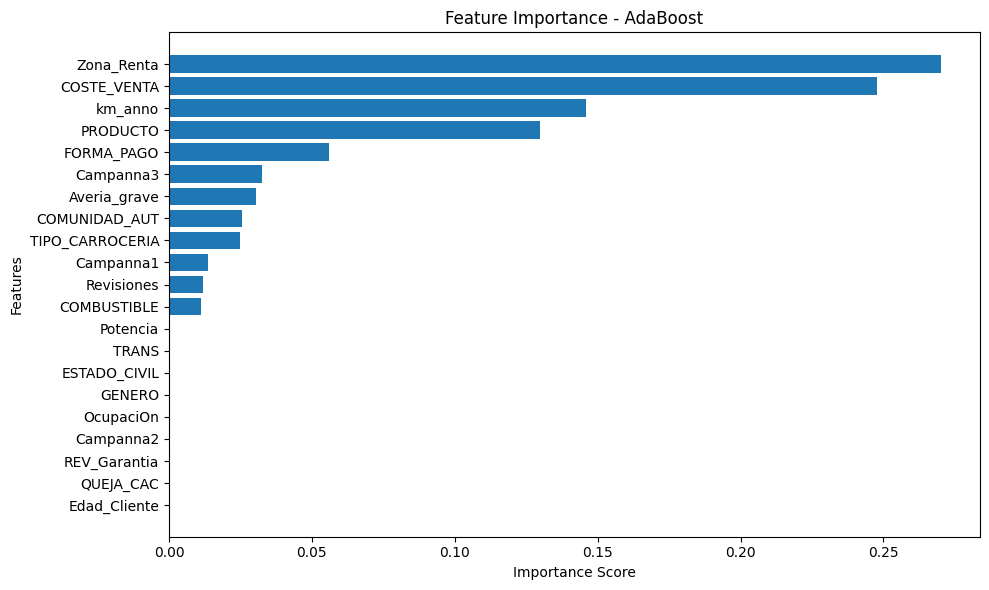

In [234]:
feature_importances = ab_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - AdaBoost')
plt.tight_layout()
plt.show()

In [235]:
importance_df.tail(10)

,Feature,Importance
2,COMBUSTIBLE,0.011317
3,Potencia,0.000000
4,TRANS,0.000000
6,ESTADO_CIVIL,0.000000
7,GENERO,0.000000
8,OcupaciOn,0.000000
10,Campanna2,0.000000
13,REV_Garantia,0.000000
15,QUEJA_CAC,0.000000
19,Edad_Cliente,0.000000


En la evaluación de importancia de características obtenida con el modelo **AdaBoost**, observamos que varias variables presentan una importancia extremadamente baja o nula. Esto sugiere que no están contribuyendo de manera significativa a las predicciones y podrían eliminarse para optimizar el modelo.

Las variables con importancia de características nula pueden ser eliminada, no tienen contribución al modelo.

### **Evaluación.**

In [236]:
print("Train set score (Accuracy) =", accuracy_score(y_train, ab_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, ab_model.predict(X_test)))

# Matriz de confusión
conf_mat = confusion_matrix(y_test, ab_model.predict(X_test))
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, ab_model.predict(X_test)))

Train set score (Accuracy) = 0.8007445883585617
Test set score (Accuracy) = 0.8032991529201962
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7353 │            765 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1441 │           1656 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      8118
           1       0.68      0.53      0.60      3097

    accuracy                           0.80     11215
   macro avg       0.76      0.72      0.73     11215
weighted avg       0.79      0.80      0.80     11215



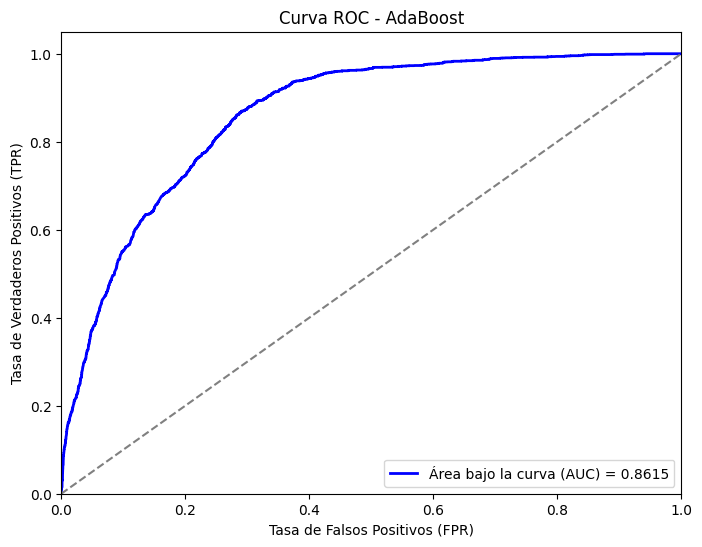

In [237]:
y_probs = ab_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - AdaBoost')
plt.legend(loc="lower right")
plt.show()

In [238]:
new_results = pd.DataFrame({
    'Model': ['AdaBoost'],
    'Umbral': [0.5],
    'Accuracy': [accuracy_score(y_test, ab_model.predict(X_test))],
    'Precision': [precision_score(y_test, ab_model.predict(X_test))],
    'Recall': [recall_score(y_test, ab_model.predict(X_test))],
    'F1': [f1_score(y_test, ab_model.predict(X_test))],
    'AUC': [roc_auc]
})
results = pd.concat([results, new_results], ignore_index=True)
display(results)

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399
3,XGBoost,0.47,0.869639,0.762271,0.767194,0.764725,0.945399
4,Gradient Boosting,0.50,0.843067,0.742474,0.660962,0.699351,0.916391
5,Gradient Boosting,0.47,0.839144,0.710381,0.704876,0.707618,0.916391
6,AdaBoost,0.50,0.803299,0.684015,0.534711,0.600217,0.861495


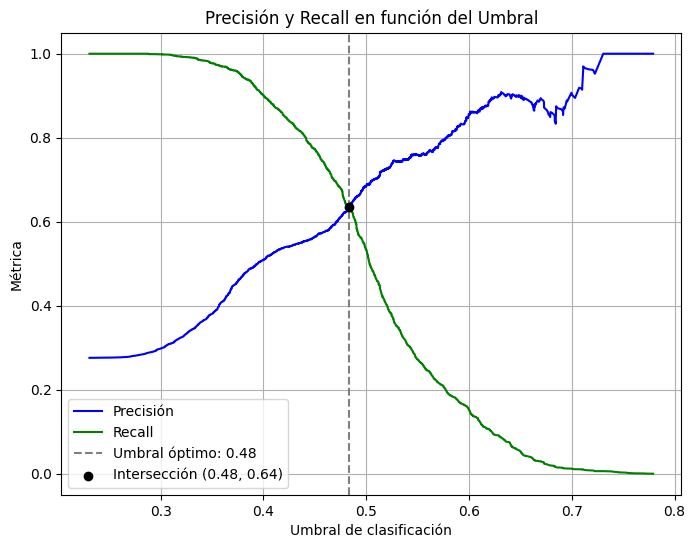

In [239]:
# Obtener probabilidades del modelo.
y_scores = ab_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersección entre precisión y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral óptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersección ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.grid(True)
plt.legend()
plt.title("Precisión y Recall en función del Umbral")
plt.show()

In [240]:
nuevo_umbral = 0.48
y_pred_new = (y_probs >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, ab_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.8007445883585617
Test set score (Accuracy) = 0.7938475256353098
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           6912 │           1206 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1106 │           1991 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      8118
           1       0.62      0.64      0.63      3097

    accuracy                           0.79     11215
   macro avg       0.74      0.75      0.74     11215
weighted avg       0.80      0.79      0.79     11215



In [241]:
new_results = pd.DataFrame({
    'Model': ['AdaBoost'],
    'Umbral': [0.48],
    'Accuracy': [accuracy_score(y_test, y_pred_new)],
    'Precision': [precision_score(y_test, y_pred_new)],
    'Recall': [recall_score(y_test, y_pred_new)],
    'F1': [f1_score(y_test, y_pred_new)],
    'AUC': [roc_auc_score(y_test, y_probs)]
})

results = pd.concat([results, new_results], ignore_index=True)
display(results)

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399
3,XGBoost,0.47,0.869639,0.762271,0.767194,0.764725,0.945399
4,Gradient Boosting,0.50,0.843067,0.742474,0.660962,0.699351,0.916391
5,Gradient Boosting,0.47,0.839144,0.710381,0.704876,0.707618,0.916391
6,AdaBoost,0.50,0.803299,0.684015,0.534711,0.600217,0.861495
7,AdaBoost,0.48,0.793848,0.622771,0.642880,0.632666,0.861495


El modelo **AdaBoost** ha mostrado un desempeño limitado en la predicción de la propensión de compra de un segundo vehículo, con una precisión y AUC inferiores a las de otros modelos evaluados. Si bien su naturaleza basada en combinaciones secuenciales de clasificadores débiles le otorga robustez ante datos ruidosos, su rendimiento sugiere que no es la opción más efectiva para este caso específico.

El ajuste del umbral ha permitido mejorar el **recall**, lo que indica una mayor capacidad para identificar a los clientes con potencial de recompra. Sin embargo, esta mejora no se traduce en un equilibrio adecuado con la **precisión**, lo que podría derivar en un incremento de falsos positivos y, por ende, en una asignación ineficiente de recursos en las estrategias de marketing y ventas.

Dado su rendimiento, **AdaBoost** parece ser menos competitivo en comparación con **XGBoost, Random Forest y Gradient Boosting**, lo que sugiere que su uso debería reconsiderarse. Si se opta por seguir explorándolo, sería recomendable realizar un ajuste más profundo de sus hiperparámetros para evaluar posibles mejoras en su capacidad predictiva.

## **Comparación de Modelos.**

### **Evaluación de métricas.**

En la evaluación de distintos modelos para predecir la **propensión de compra de un segundo vehículo**, los resultados indican que **XGBoost** y **Random Forest** son las opciones más sólidas, mientras que **Gradient Boosting** y **AdaBoost** presentan un desempeño inferior en este caso específico.

El modelo **XGBoost** se destaca como la mejor opción, logrando una combinación óptima entre **precisión y recall**, lo que permite identificar con gran eficacia a los clientes con mayor probabilidad de recompra. Su alto **AUC** confirma su capacidad para discriminar correctamente entre compradores y no compradores, lo que lo convierte en una herramienta clave para **optimizar las estrategias de marketing y ventas**.

**Random Forest** también muestra un rendimiento sólido, con una alta precisión y un buen balance entre **recall** y **precisión**. Su desempeño es competitivo frente a XGBoost y puede ser una alternativa viable si se busca un modelo robusto y menos complejo computacionalmente.

Por otro lado, **Gradient Boosting**, aunque estable, tiene una menor capacidad predictiva en comparación con XGBoost y Random Forest. Su menor **precisión y recall** sugieren que no logra un equilibrio óptimo entre la captura de clientes potenciales y la reducción de falsos positivos. Si bien puede mejorar con ajuste de hiperparámetros, no parece ser la opción más eficiente en su configuración actual.

Finalmente, **AdaBoost** es el modelo con el rendimiento más limitado, mostrando dificultades para identificar correctamente a los clientes con alta probabilidad de recompra. Su menor **AUC** y la falta de equilibrio en sus métricas hacen que su aplicación en este caso sea menos recomendable.

In [242]:
display(results)

,Model,Umbral,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.50,0.860366,0.767938,0.708428,0.736984,0.933726
1,Random Forest,0.47,0.858761,0.742390,0.748143,0.745256,0.933726
2,XGBoost,0.50,0.871511,0.781250,0.742654,0.761463,0.945399
3,XGBoost,0.47,0.869639,0.762271,0.767194,0.764725,0.945399
4,Gradient Boosting,0.50,0.843067,0.742474,0.660962,0.699351,0.916391
5,Gradient Boosting,0.47,0.839144,0.710381,0.704876,0.707618,0.916391
6,AdaBoost,0.50,0.803299,0.684015,0.534711,0.600217,0.861495
7,AdaBoost,0.48,0.793848,0.622771,0.642880,0.632666,0.861495


**Conclusión General:** El modelo **XGBoost** es la mejor alternativa para la predicción de recompra, seguido de cerca por **Random Forest**. Ambos modelos cumplen con los objetivos establecidos en el **Project Charter**, permitiendo una mejor segmentación de clientes y una asignación más eficiente de recursos en campañas de marketing. **Gradient Boosting y AdaBoost**, en su configuración actual, no ofrecen un rendimiento competitivo y podrían requerir un ajuste más profundo de hiperparámetros si se considerara su implementación.

#### **Matrices de confusión.**

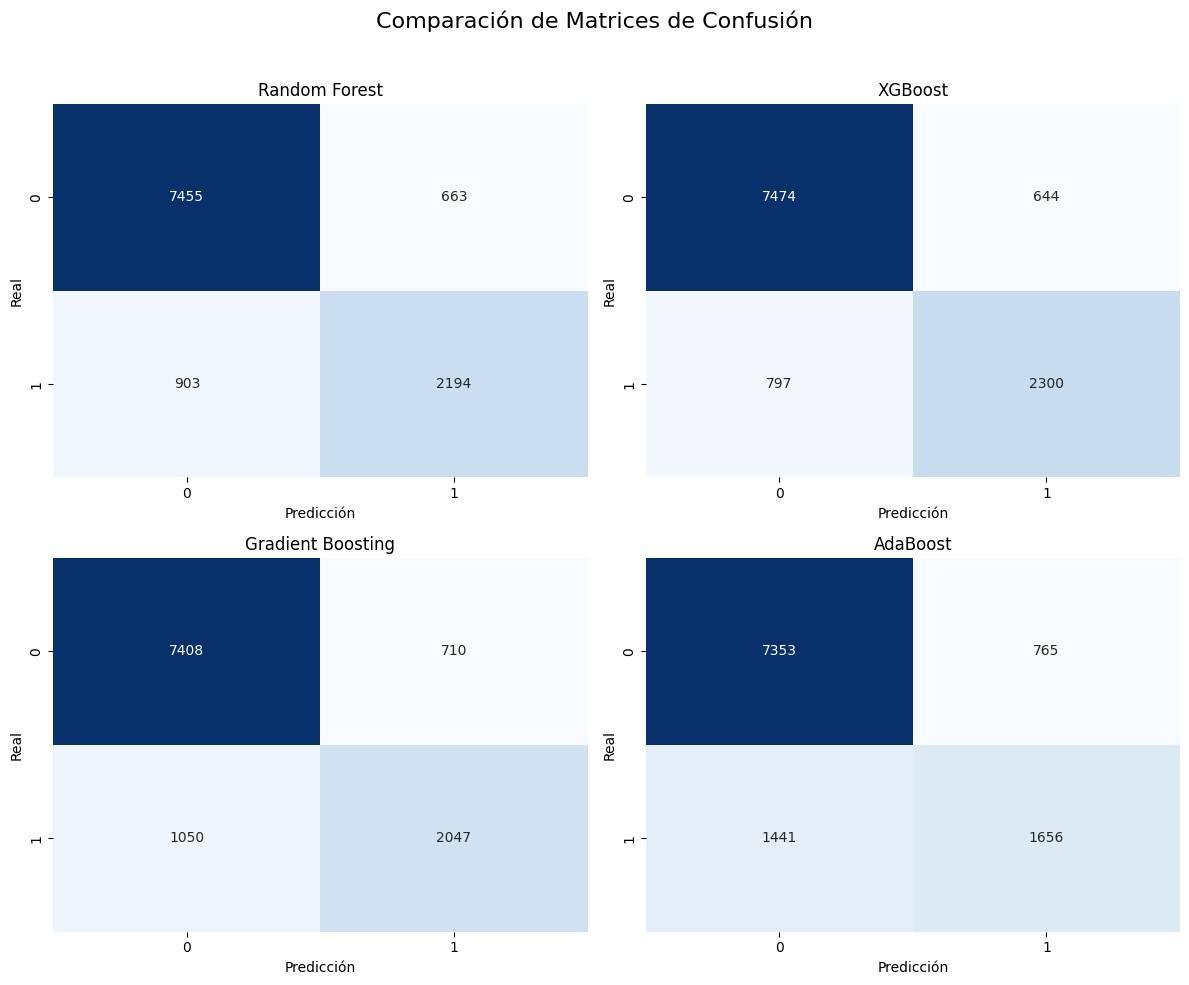

In [243]:
# Obtención de matrices de confusión para cada modelo.
conf_matrix_rf = confusion_matrix(y_test, rf_model.predict(X_test))
conf_matrix_xgb = confusion_matrix(y_test, xgb_model.predict(X_test))
conf_matrix_gb = confusion_matrix(y_test, gb_model.predict(X_test))
conf_matrix_ab = confusion_matrix(y_test, ab_model.predict(X_test))

# Creación de subplots para visualizar las matrices de confusión.
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparación de Matrices de Confusión", fontsize=16)

# Modelos.
models = ["Random Forest", "XGBoost", "Gradient Boosting", "AdaBoost"]
conf_matrices = [conf_matrix_rf, conf_matrix_xgb, conf_matrix_gb, conf_matrix_ab]
ax_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Gráficos.
for ax, model, matrix, pos in zip(axes.flat, models, conf_matrices, ax_positions):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(model)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### **Feature Importance.**

In [244]:
# Creación de un DataFrame con la importancia de características de cada modelo base.
rf_importance = pd.DataFrame({'Feature': X_train.columns, 'RandomForest': rf_model.feature_importances_})
xgb_importance = pd.DataFrame({'Feature': X_train.columns, 'XGBoost': xgb_model.feature_importances_})
gb_importance = pd.DataFrame({'Feature': X_train.columns, 'GradientBoosting': gb_model.feature_importances_})
ab_importance = pd.DataFrame({'Feature': X_train.columns, 'AdaBoost': ab_model.feature_importances_})

feature_importance_df = rf_importance.merge(xgb_importance, on="Feature") \
                                     .merge(gb_importance, on="Feature") \
                                     .merge(ab_importance, on="Feature")

feature_importance_df.head()

,Feature,RandomForest,XGBoost,GradientBoosting,AdaBoost
0,PRODUCTO,0.058922,0.115129,0.148452,0.129938
1,TIPO_CARROCERIA,0.031090,0.016346,0.002085,0.024761
2,COMBUSTIBLE,0.014333,0.031110,0.002469,0.011317
3,Potencia,0.016183,0.024480,0.004510,0.000000
4,TRANS,0.007850,0.014153,0.000000,0.000000


In [245]:
feature_importance_df.to_csv("../benchmarking/baseline_models/feature_importance.csv", index=False)

### **Evaluación de curvas ROC.**

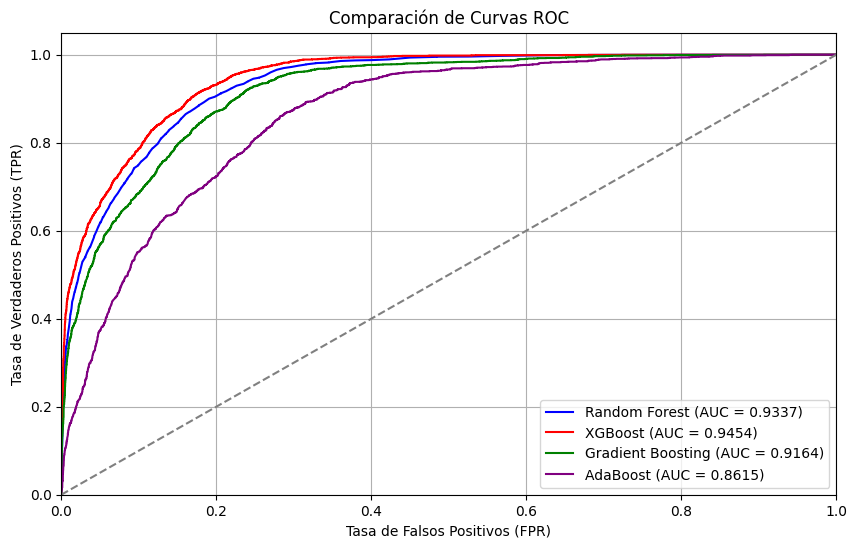

In [246]:
# Cálculo de las curvas ROC para cada modelo.
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_ab, tpr_ab, _ = roc_curve(y_test, ab_model.predict_proba(X_test)[:, 1])
roc_auc_ab = auc(fpr_ab, tpr_ab)

# Gráfico de las curvas ROC.
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', color='red')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})', color='green')
plt.plot(fpr_ab, tpr_ab, label=f'AdaBoost (AUC = {roc_auc_ab:.4f})', color='purple')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Línea base.

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

La comparación de las curvas **ROC** confirma que el modelo **XGBoost** es el más eficiente en la predicción de la propensión de compra de un segundo vehículo, logrando la mejor capacidad para diferenciar entre clientes que recomprarán y aquellos que no. Su desempeño lo convierte en la opción más sólida para optimizar estrategias de marketing y ventas.

El modelo **Random Forest** también ofrece un rendimiento altamente competitivo, con un comportamiento muy cercano al de XGBoost. Su robustez y facilidad de interpretación lo hacen una alternativa viable, especialmente si se busca una opción más estable y menos exigente en términos computacionales.

Por otro lado, **Gradient Boosting** muestra una capacidad predictiva aceptable, aunque inferior a XGBoost y Random Forest. Si bien puede ser útil en algunos escenarios, no alcanza el mismo nivel de precisión y discriminación, lo que podría traducirse en un menor impacto en la toma de decisiones estratégicas.

Finalmente, **AdaBoost** presenta el rendimiento más bajo de todos los modelos evaluados. Su menor capacidad para distinguir entre clientes potenciales y no compradores sugiere que no es la mejor opción para este caso de uso, ya que podría generar más errores en la segmentación de clientes.

**Conclusión General.**
- **XGBoost** es el modelo más efectivo, con la mejor capacidad de clasificación.
- **Random Forest** es una alternativa sólida, con un rendimiento muy cercano.
- **Gradient Boosting** es una opción aceptable, pero menos eficiente en comparación con los anteriores.
- **AdaBoost** no es recomendable para este caso, debido a su menor capacidad predictiva.

En base a estos resultados, se recomienda utilizar **XGBoost o Random Forest** para la predicción de la propensión de compra, garantizando una segmentación más precisa y un mejor aprovechamiento de los recursos en las campañas de marketing y ventas. 🚀

### **Selección de modelos.**

Tras la evaluación de los modelos base, se ha determinado que **XGBoost y Random Forest** son las opciones más prometedoras para la predicción de la propensión de compra de un segundo vehículo. Ambos modelos han mostrado un **alto AUC y un equilibrio adecuado entre precisión y recall**, lo que los convierte en candidatos ideales para optimizar su desempeño mediante la **búsqueda de hiperparámetros**.

En el siguiente notebook, nos enfocaremos en **ajustar los hiperparámetros de XGBoost y Random Forest** para maximizar su rendimiento. Aunque Gradient Boosting ha mostrado un desempeño aceptable, su menor efectividad en comparación con los otros dos modelos hace que no sea prioritario en esta fase de optimización. AdaBoost, debido a su bajo AUC y menor capacidad predictiva, será descartado de la búsqueda de hiperparámetros.

In [247]:
results.to_csv('../benchmarking/baseline_models/baseline_models.csv', index=False)